Prereq:
You will need an environment with python 2.7. Python 3 is not supported by this tool (at least this repository).

```bash
git clone https://github.com/phe-bioinformatics/snapperdb
cd snapperdb && pip install -r requirements.txt
sudo apt install bwa openjdk-8-jdk samtools elixir
mix archive.install https://github.com/phoenixframework/archives/raw/master/phoenix_new.ez
cp config.txt snapperdb/user_configs/
cp input/2011C-3609.fasta snapperdb/reference_genomes/2011C-3609.fa
cp input/*.fastq.gz snapperdb/reference_genomes
sudo -u postgres psql postgres

ALTER USER postgres PASSWORD 'DaPassword'; ALTER ROLE;
CREATE DATABASE escherichia_coli_1405waexk
\q

pip install psycopg2
cd snapperdb && pip install -r requirements.txt
```

In [ ]:
# Download picard
!wget "https://github.com/broadinstitute/picard/releases/download/2.23.1/picard.jar"

In [ ]:
!wget https://console.cloud.google.com/storage/browser/_details/gatk-software/package-archive/gatk/GenomeAnalysisTK-3.8-1-0-gf15c1c3ef.tar.bz2

Extract the file GenomeAnalysisTK.jar to the cwd

In [ ]:
%%bash
export GATK_JAR="${PWD}/GenomeAnalysisTK.jar"

In [ ]:
%%bash
export PICARD_JAR="${PWD}/picard.jar"

In [1]:
%run ../../multibench.py

In [2]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'
input_files_1 = [os.path.basename(f) for f in glob.glob('input/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

bigsi_dir = 'bigsi-data'

['2014C-3599', '2014C-3656', '2014C-3840', '2014C-3655', '2014C-3598', '2014C-3850', '2014C-3857', '2014C-3907', '2014C-3600']


In [3]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [4]:
sample_sizes = [1]

In [5]:
import psycopg2, glob, os
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

reference_genome_name = "2011C-3609"

dbname, user, password = "escherichia_coli_1405waexk", "postgres", "DaPassword"

def reset_func():
    # Remove processed files for the reference genome
    for file in glob.glob("snapperdb/reference_genomes/%s.*" % reference_genome_name):
        if(file.split(".")[-1] != "fa"):
            os.remove(file)
    
    # https://github.com/phe-bioinformatics/snapperdb#deleting-or-purging-your-database
    
    # Connect to the database, drop the whole database made by snapperdb and close the connection
    
    psql_conn = psycopg2.connect("user=%s host='localhost' password=%s" % (user, password));
    psql_conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT);
    
    psql_cursor = psql_conn.cursor();
    
    drop_db_statement = "DROP DATABASE %s;" % dbname;
    psql_cursor.execute(drop_db_statement);
    
    psql_cursor.close();
    psql_conn.close();
        
    
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(input_size):
    return input_samples[:input_size]

# Index

make_snpdb_command = {
    "use_parallel": False,
    "command": "python snapperdb/run_snapperdb.py make_snpdb -c config.txt"
}

fastq_to_db_command = {
    "command": 'python snapperdb/run_snapperdb.py fastq_to_db -c "${PWD}/snapperdb/user_configs/config.txt" "${PWD}/input/%_1.fastq.gz" "${PWD}/input/%_2.fastq.gz"',
    "parallel_args": "-j 1 -I%"
}

update_distance_matrix_command = {
    "use_parallel": False,
    "command": "python snapperdb/run_snapperdb.py update_distance_matrix -c config.txt"
}

update_clusters_command = {
    "use_parallel": False,
    "command": "python snapperdb/run_snapperdb.py update_clusters -c config.txt"
}

# Query

get_strains_command = {
    "use_parallel": False,
    "command": "python snapperdb/run_snapperdb.py get_strains -c config.txt"
}

multibench_results, debug_str = multi_cmdbench({
"index": [make_snpdb_command, fastq_to_db_command, update_distance_matrix_command, update_clusters_command],
"query": [get_strains_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results)


In [10]:
# print(debug_str)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 14395916288.0, 'disk_read': 6571030656.0, 'disk_write': 5539948185.0, 'runtime': 1225.21}]


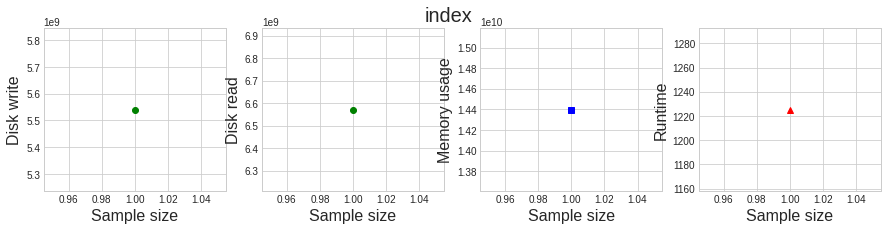

In [8]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 28205056.0, 'disk_read': 2514279.0, 'disk_write': 428.0, 'runtime': 0.08}]


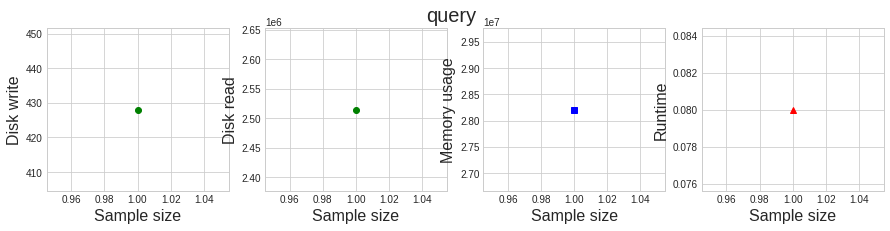

In [9]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")